In [ ]:
# Gambler ruin

ph = 0.4
goal = 100

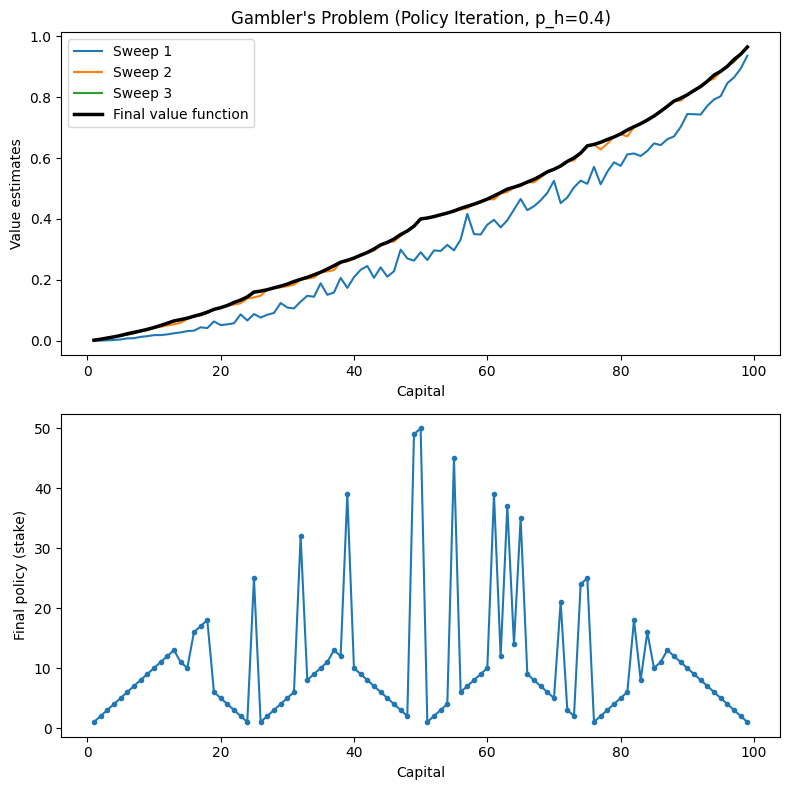

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gambler_policy_iteration_with_plots(p_h=0.4, 
                                        theta=1e-9, 
                                        max_eval_iterations=10000, 
                                        max_policy_iterations=50):
    """
    Applies policy iteration to the Gambler's problem and stores intermediate
    value functions for plotting.

    Args:
        p_h (float): probability of the coin coming up heads.
        theta (float): evaluation convergence threshold.
        max_eval_iterations (int): max sweeps in each policy-evaluation phase.
        max_policy_iterations (int): max outer policy-iteration loops.

    Returns:
        all_values (list of np.ndarray): V(s) after each policy evaluation 
                                         (including final).
        final_policy (np.ndarray): final policy array, policy[s] = best stake.
    """

    # States are 0..100 (0 and 100 are terminal)
    # Initialize value function
    V = np.zeros(101)
    # Random initial policy (legal stakes only) for states 1..99
    policy = np.zeros(101, dtype=int)
    for s in range(1, 100):
        policy[s] = np.random.randint(1, min(s, 100 - s) + 1)

    # We'll store the value function after each policy evaluation
    all_values = []

    # One-step lookahead function
    def action_return(s, a, value_array):
        """
        Computes the expected return if we bet 'a' from state s:
          - With probability p_h, next state is s+a (reward=1 if s+a==100 else 0)
          - With probability (1-p_h), next state is s-a (reward=0)
        """
        s_heads = s + a
        r_heads = 1.0 if s_heads == 100 else 0.0

        s_tails = s - a
        r_tails = 0.0

        return p_h  * (r_heads + value_array[s_heads]) \
             + (1-p_h)*(r_tails + value_array[s_tails])

    # Main loop
    for iteration in range(max_policy_iterations):
        #######################################################################
        # 1) Policy Evaluation: repeatedly update V(s) to match current policy
        #######################################################################
        eval_iter = 0
        while True:
            delta = 0
            eval_iter += 1
            for s in range(1, 100):
                old_v = V[s]
                a = policy[s]
                V[s] = action_return(s, a, V)
                delta = max(delta, abs(V[s] - old_v))

            if delta < theta or eval_iter >= max_eval_iterations:
                # Done converging the value function for this policy
                break

        # Store the (copied) value function at the end of the policy evaluation
        all_values.append(V.copy())

        #######################################################################
        # 2) Policy Improvement
        #######################################################################
        policy_stable = True
        for s in range(1, 100):
            old_a = policy[s]

            # Evaluate all legal actions from s
            actions = range(1, min(s, 100 - s) + 1)
            action_values = [action_return(s, a, V) for a in actions]
            best_action = actions[np.argmax(action_values)]

            policy[s] = best_action
            if best_action != old_a:
                policy_stable = False

        if policy_stable:
            # We have converged to an optimal policy
            break

    # If we exited by hitting max_policy_iterations, we still store
    # the final set of values. (But we already have them in all_values[-1].)
    final_policy = policy.copy()
    return all_values, final_policy

if __name__ == "__main__":
    # Run policy iteration
    p_h = 0.4
    all_values, final_policy = gambler_policy_iteration_with_plots(p_h=p_h)

    # Now let's plot:
    # -- We’ll plot the value function after the first 3 evaluations
    #    plus the final one (which might be the last entry of all_values).
    # -- Then we’ll plot the final policy.

    # Decide how many sweeps we want to visualize
    # If we have fewer than 3 sweeps, it’s okay: we’ll just plot what we have
    sweeps_to_show = min(3, len(all_values)-1)  # minus 1 so we can show final separately
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

    # 1) Plot the value functions
    capitals = np.arange(1,100)
    for i in range(sweeps_to_show):
        ax1.plot(capitals, all_values[i][1:100], 
                 label=f"Sweep {i+1}")
    # "Final" is the last array in all_values
    ax1.plot(capitals, all_values[-1][1:100], 
             label="Final value function", 
             linewidth=2.5, color='k')
    ax1.set_xlabel("Capital")
    ax1.set_ylabel("Value estimates")
    ax1.legend(loc='best')
    ax1.set_title(f"Gambler's Problem (Policy Iteration, p_h={p_h})")

    # 2) Plot the final policy
    ax2.plot(capitals, final_policy[1:100], marker='.', linestyle='-')
    ax2.set_xlabel("Capital")
    ax2.set_ylabel("Final policy (stake)")

    plt.tight_layout()
    plt.show()
